# Data Science Challenge

In [1]:
# If additional packages are needed that are not installed by default, uncomment the last two lines of this 
# cell and replace <package list> with a list of additional packages.
# This will ensure the notebook has all the dependencies and works everywhere

import sys
!{sys.executable} -m pip install scikit-learn

In [2]:
#Libraries

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option("display.max_columns", 101)
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.model_selection import train_test_split
from datetime import datetime
import statsmodels.formula.api as sm

## Data Description

Column | Description
:---|:---
`id` | Record index
`timestamp` | Datetime (YYYY:MM:DD HH AM/PM)
`season` | Season (spring, summer, fall, winter)
`holiday` | Whether day is a holiday or not (Yes or No)
`workingday` | Whether day is a working day or not (Yes or No)
`weather`| Weather condition (Clear or partly cloudy, Mist, Light snow or rain, heavy rain/ice pellets/ snow + fog 
`temp`| Average temperature recorded for the hour ( in degree Celsius)
`temp_feel`| Average feeling temperature recorded for the hour ( in degree Celsius)
`hum`| Average humidity recorded for the hour (in %)
`windspeed`| Average wind speed recorded for the hour (in miles/hour)
`demand`| Hourly count of bikes rented

## Data Cleaning and Prepping

In [3]:
# The dataset is already loaded below
data = pd.read_csv("train.csv")

In [4]:
data.head()

,id,timestamp,season,holiday,workingday,weather,temp,temp_feel,humidity,windspeed,demand
0,1,2017-01-01 00:00:00,spring,No,No,Clear or partly cloudy,9.84,14.395,81.0,0.0,2.772589
1,2,2017-01-01 01:00:00,spring,No,No,Clear or partly cloudy,9.02,13.635,80.0,0.0,3.688879
2,3,2017-01-01 02:00:00,spring,No,No,Clear or partly cloudy,9.02,13.635,80.0,0.0,3.465736
3,4,2017-01-01 03:00:00,spring,No,No,Clear or partly cloudy,9.84,14.395,75.0,0.0,2.564949
4,5,2017-01-01 04:00:00,spring,No,No,Clear or partly cloudy,9.84,14.395,75.0,0.0,0.000000


In [5]:
#Explore columns
data.columns

Index(['id', 'timestamp', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'temp_feel', 'humidity', 'windspeed', 'demand'],
      dtype='object')

In [6]:
#Description
data.describe()

,id,temp,temp_feel,humidity,windspeed,demand
count,8708.000000,7506.000000,8606.000000,8669.00000,8508.000000,8708.000000
mean,4354.500000,20.089454,23.531261,60.99354,13.048589,4.452725
std,2513.927405,8.023304,8.737997,19.67989,8.311058,1.493963
min,1.000000,0.820000,0.760000,0.00000,0.000000,0.000000
25%,2177.750000,13.940000,15.910000,46.00000,7.001500,3.637586
50%,4354.500000,20.500000,24.240000,60.00000,12.998000,4.867534
75%,6531.250000,26.240000,31.060000,77.00000,19.001200,5.556828
max,8708.000000,41.000000,45.455000,100.00000,56.996900,6.792344


In [7]:
data.weather.unique()

array(['Clear or partly cloudy', 'Mist', 'Light snow or rain',
       'heavy rain/ice pellets/snow + fog'], dtype=object)

In [8]:
# turn categorical data into numeric and extract year, month, hour, and weekday
def pre_processing(data):
    new = data.replace("spring", 1)
    new = new.replace("summer", 2)
    new = new.replace("fall", 3)
    new = new.replace("winter", 4)
    new = new.replace("No", 0)
    new = new.replace("Yes", 1)
    new = new.replace("Clear or partly cloudy", 1)
    new = new.replace("Mist", 2)
    new = new.replace("Light snow or rain", 3)
    new = new.replace("heavy rain/ice pellets/snow + fog", 4)
    temp = pd.DatetimeIndex(new['timestamp'])
    new['year'] = temp.year
    new['month'] = temp.month
    new['hour'] = temp.hour
    new['weekday'] = temp.weekday
    return new
newdata = pre_processing(data)
newdata.head()

,id,timestamp,season,holiday,workingday,weather,temp,temp_feel,humidity,windspeed,demand,year,month,hour,weekday
0,1,2017-01-01 00:00:00,1,0,0,1,9.84,14.395,81.0,0.0,2.772589,2017,1,0,6
1,2,2017-01-01 01:00:00,1,0,0,1,9.02,13.635,80.0,0.0,3.688879,2017,1,1,6
2,3,2017-01-01 02:00:00,1,0,0,1,9.02,13.635,80.0,0.0,3.465736,2017,1,2,6
3,4,2017-01-01 03:00:00,1,0,0,1,9.84,14.395,75.0,0.0,2.564949,2017,1,3,6
4,5,2017-01-01 04:00:00,1,0,0,1,9.84,14.395,75.0,0.0,0.000000,2017,1,4,6


In [9]:
#defining the features at hand
features = ['season', 'holiday', 'workingday', 'weather', 'temp', 'temp_feel', 'humidity', 'windspeed', 'year', 'month', 'weekday', 'hour']



Text(0.5, 1.0, 'Histogram of demand')

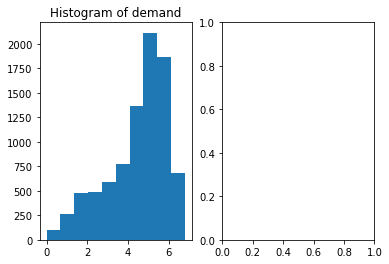

In [10]:
rentals = newdata['demand']
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist((rentals))
ax1.set_title('Histogram of demand')
# ax2.hist(np.log(rentals))
# ax2.set_title('Histogram of log(demand)')

The demand variable distribution is skewed to the left which is important to note.

## Data Visualization and Feature Engineering

In [56]:
# Removing outliers and dropping some rows where the windspeed was 0

rentals_describe =  newdata['demand'].describe()

IQR = rentals_describe['75%'] - rentals_describe['25%']
outlier = rentals_describe['75%'] + 1.5*IQR

train = newdata[newdata['demand'] <= outlier]
train = train[(train['windspeed'] != 0)]

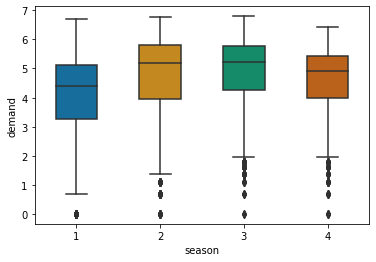

In [12]:
#grouping by seasoning and plotting the boxplot
season_group = (train.groupby("season"))["demand"].sum()
season_group.reset_index(name = "rentals")
sns.boxplot(y = "demand", x = "season", data = train, width = 0.5, palette = "colorblind")
plt.show()

The demand is the lowest in the fall and the highest in the summer.

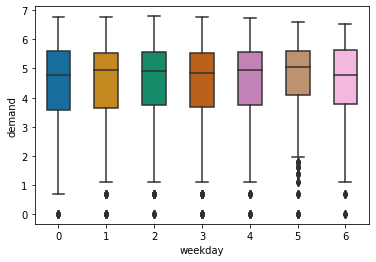

In [13]:
#grouping by weekday and plotting the box plot
weekday_group = (train.groupby("weekday"))["demand"].sum()
weekday_group.reset_index(name = "rentals")
sns.boxplot(y = "demand", x = "weekday", data = train, width = 0.5, palette = "colorblind")
plt.show()

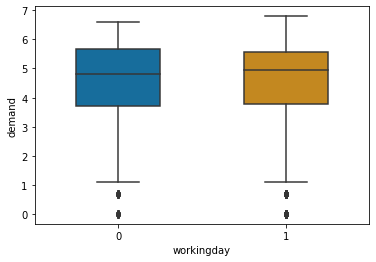

In [14]:
#box plotting the difference between the workday and a non-workday
workingday_group = (train.groupby("workingday"))["demand"].sum()
workingday_group.reset_index(name = "rentals")
sns.boxplot(y = "demand", x = "workingday", data = train, width = 0.5, palette = "colorblind")
plt.show()

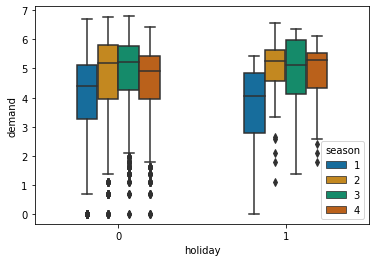

In [15]:
#grouping be season and seeing the difference between holiday and non-holiday
sns.boxplot(y = "demand", x= "holiday", data = train, hue = "season", width = 0.5, palette = "colorblind")

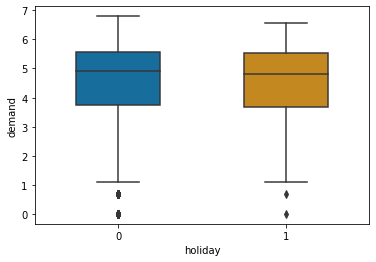

In [16]:
#box plotting the difference in holiday and non-holiday
holiday_group = (train.groupby("holiday"))["demand"].sum()
holiday_group.reset_index(name = "rentals")
sns.boxplot(y = "demand", x = "holiday", data = train, width = 0.5, palette = "colorblind")
plt.show()

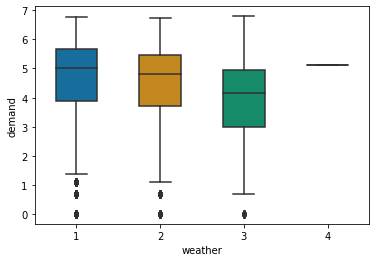

In [17]:
#grouping by weather and plotting the box plot
weather_group = (train.groupby("weather"))["demand"].sum()
weather_group.reset_index(name = "rentals")
sns.boxplot(y = "demand", x = "weather", data = train, width = 0.5, palette = "colorblind")
plt.show()

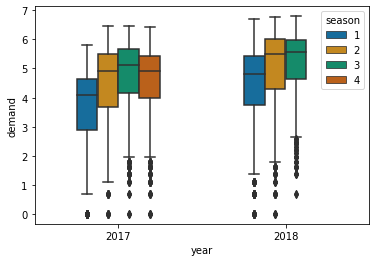

In [18]:
# grouping by season and seeing the difference between the 2 years
sns.boxplot(y = "demand", x= "year", data = train, hue = "season", width = 0.5, palette = "colorblind")

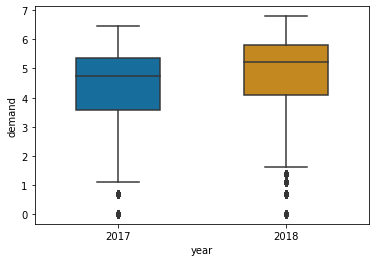

In [19]:
# box plotting the change in year
year_group = (train.groupby("year"))["demand"].sum()
year_group.reset_index(name = "rentals")
sns.boxplot(y = "demand", x = "year", data = train, width = 0.5, palette = "colorblind")
plt.show()

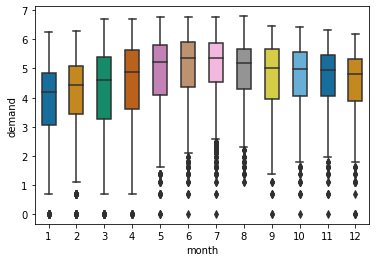

In [20]:
# box plotting the change in month
month_group = (train.groupby("month"))["demand"].sum()
month_group.reset_index(name = "rentals")
sns.boxplot(y = "demand", x = "month", data = train, width = 0.5, palette = "colorblind")
plt.show()

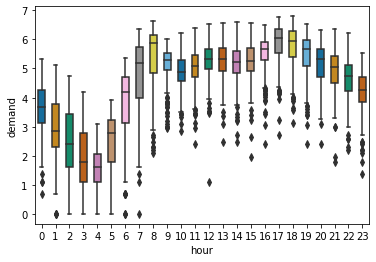

In [21]:
# box plotting the change in hour
hour_group = (train.groupby("hour"))["demand"].sum()
hour_group.reset_index(name = "rentals")
sns.boxplot(y = "demand", x = "hour", data = train, width = 0.5, palette = "colorblind")
plt.show()

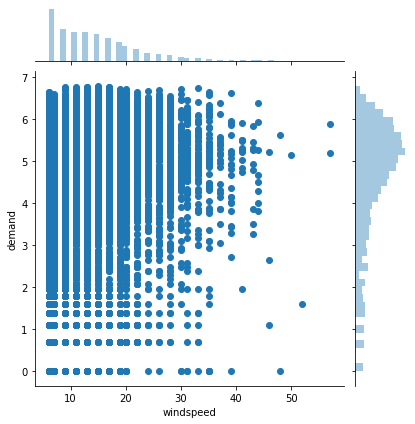

In [22]:
#plotting to see if there is a relation between demand and windspeed
sns.jointplot(y = "demand", x = "windspeed", data = train)

## Find correlation between variables for the regression

In [23]:
corr = train.corr()
corr.style.background_gradient().set_precision(1)

,id,season,holiday,workingday,weather,temp,temp_feel,humidity,windspeed,demand,year,month,hour,weekday
id,1,0.2,0.003,-0.0003,-0.04,0.3,0.3,-0.05,-0.09,0.2,0.8,0.2,0.001,-0.008
season,0.2,1,0.01,-0.009,0.007,0.4,0.4,0.2,-0.1,0.1,-0.3,1,0.001,0.008
holiday,0.003,0.01,1,-0.2,-0.001,-0.02,-0.03,-0.03,0.03,-0.002,0.01,-0.02,0.01,-0.1
workingday,-0.0003,-0.009,-0.2,1,0.04,0.04,0.04,0.004,0.01,-0.01,-0.0005,0.001,0.004,-0.2
weather,-0.04,0.007,-0.001,0.04,1,-0.05,-0.06,0.4,-0.02,-0.1,-0.05,0.01,-0.03,-0.008
temp,0.3,0.4,-0.02,0.04,-0.05,1,1,-0.05,-0.05,0.4,0.05,0.4,0.1,-0.03
temp_feel,0.3,0.4,-0.03,0.04,-0.06,1,1,-0.03,-0.09,0.4,0.05,0.4,0.1,-0.03
humidity,-0.05,0.2,-0.03,0.004,0.4,-0.05,-0.03,1,-0.3,-0.3,-0.2,0.2,-0.3,-0.04
windspeed,-0.09,-0.1,0.03,0.01,-0.02,-0.05,-0.09,-0.3,1,0.1,-0.006,-0.1,0.1,-0.03
demand,0.2,0.1,-0.002,-0.01,-0.1,0.4,0.4,-0.3,0.1,1,0.1,0.2,0.6,0.03


In [24]:
dataY = train['demand']
dataX = train.drop(columns = ['demand'], axis = 1)

In [37]:
#creating testing and training variables
X_train, X_test, y_train, y_test = train_test_split(train, dataY, test_size = 0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
X_train.head()

#converting variables into categories
X_train['season'] = X_train['season'].astype('category')
X_train['hour'] = X_train['hour'].astype('category')
X_train['weekday'] = X_train['weekday'].astype('category')
X_train['month'] = X_train['month'].astype('category')

(6168, 15) (6168,)
(1543, 15) (1543,)


In [40]:
(X_test)

,id,timestamp,season,holiday,workingday,weather,temp,temp_feel,humidity,windspeed,demand,year,month,hour,weekday
6820,6821,2018-04-02 12:00:00,2,0,1,1,18.04,21.970,44.0,30.0026,5.638355,2018,4,12,0
2975,2976,2017-07-12 21:00:00,3,0,1,1,33.62,37.120,43.0,7.0015,5.552960,2017,7,21,2
7669,7670,2018-05-18 22:00:00,2,0,1,1,22.96,26.515,52.0,22.0028,5.525453,2018,5,22,4
7475,7476,2018-05-10 20:00:00,2,0,1,1,21.32,25.000,40.0,22.0028,5.924256,2018,5,20,3
164,165,2017-01-08 03:00:00,1,0,0,3,7.38,9.850,55.0,11.0014,1.945910,2017,1,3,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6033,6034,2018-02-07 15:00:00,1,0,1,1,NaN,21.970,38.0,12.9980,4.983607,2018,2,15,2
7137,7138,2018-04-15 18:00:00,2,0,0,1,NaN,31.820,NaN,16.9979,6.171701,2018,4,18,6
3876,3877,2017-09-12 13:00:00,3,0,1,1,29.52,33.335,54.0,7.0015,5.093750,2017,9,13,1
5611,5612,2018-01-08 22:00:00,1,0,0,1,10.66,13.635,60.0,7.0015,4.060443,2018,1,22,0


## Regression Analysis

In [26]:
#try a mixture of variables and formulas and this one yielded the highest r-squared
model_fit = sm.ols(formula = "demand ~ hour * temp + month + weather + season + windspeed", data = X_train).fit()
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                 demand   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     345.8
Date:                Wed, 22 Sep 2021   Prob (F-statistic):               0.00
Time:                        04:34:12   Log-Likelihood:                -5105.4
No. Observations:                5125   AIC:                         1.033e+04
Df Residuals:                    5064   BIC:                         1.073e+04
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.7806      0.127     

In [27]:
#fitted values
model_fitted_y = model_fit.fittedvalues
#model residuals
model_residuals = model_fit.resid
#normalized residuals
model_norm_residuals = model_fit.get_influence().resid_studentized_internal
#absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
#absolute residuals
model_abs_resid = np.abs(model_residuals)

In [28]:
# residualplot = plt.figure(1)
# residualplot.set_figheight(8)
# residualplot.set_figwidth(12)

# residualplot.axes[0] = sns.residplot(model_fitted_y, y_train, lowess = True, scatter_kws = {'alpha': 0.5},line_kws = {'color':'red', 'lw':1, 'alpha': 0.8})

# residualplot.axes[0].set_title('Residuals vs Fitted')
# residualplot.axes[0].set_xlabel('Fitted Values')
# residualplot.axes[0].set_ylabel('Residuals')


In [46]:
# mean absolute error function
def rmsle(prediction, actual):
    log1 = np.nan_to_num(np.array([v for v in prediction]))
    log2 = np.nan_to_num(np.array([v for v in actual]))
    calc = abs(log1 - log2)
    return np.mean(calc)
    

In [47]:
# performing the predictions using the fitted model and computing MSE

ypred = model_fit.predict(X_test)
predictions = ypred.values

i = 0

for v in predictions:
    if predictions[i] < 0:
        predictions[i] = 0
    i += 1
    
RMSLE = rmsle(predictions, y_test)
print("The Mean absolute error for this model is:", RMSLE)
print(predictions)
print(y_test)

The Mean absolute error for this model is: 1.1524697093026148
[5.25087476 5.74905839 5.08846123 ... 5.64130554 4.02920302        nan]
6820    5.638355
2975    5.552960
7669    5.525453
7475    5.924256
164     1.945910
          ...   
6033    4.983607
7137    6.171701
3876    5.093750
5611    4.060443
3258    5.799093
Name: demand, Length: 1543, dtype: float64


## Modeling and Machine Learning Prediction

Build a model that can predict hourly demand and identify how different features influence the decision. Please explain the findings effectively to technical and non-technical audiences using comments and visualizations, if appropriate.
- **Build an optimized model that effectively solves the business problem.**
- **The model will be evaluated on the basis of mean absolute error.**
- **Read the test.csv file and prepare features for testing.**

In [48]:
#Loading Test data
test_data=pd.read_csv('test.csv')
test_data.head()

,id,timestamp,season,holiday,workingday,weather,temp,temp_feel,humidity,windspeed
0,8709,2018-08-05 05:00:00,fall,No,No,Clear or partly cloudy,29.52,34.850,74.0,16.9979
1,8710,2018-08-05 06:00:00,fall,No,No,Clear or partly cloudy,29.52,34.850,79.0,16.9979
2,8712,2018-08-05 08:00:00,fall,No,No,Clear or partly cloudy,31.16,36.365,66.0,22.0028
3,8713,2018-08-05 09:00:00,fall,No,No,Clear or partly cloudy,32.80,38.635,59.0,23.9994
4,8714,2018-08-05 10:00:00,fall,No,No,Clear or partly cloudy,32.80,38.635,59.0,27.9993


In [49]:
#converting the test data into the format used for the model
newtest = pre_processing(test_data)
newtest.head()

,id,timestamp,season,holiday,workingday,weather,temp,temp_feel,humidity,windspeed,year,month,hour,weekday
0,8709,2018-08-05 05:00:00,3,0,0,1,29.52,34.850,74.0,16.9979,2018,8,5,6
1,8710,2018-08-05 06:00:00,3,0,0,1,29.52,34.850,79.0,16.9979,2018,8,6,6
2,8712,2018-08-05 08:00:00,3,0,0,1,31.16,36.365,66.0,22.0028,2018,8,8,6
3,8713,2018-08-05 09:00:00,3,0,0,1,32.80,38.635,59.0,23.9994,2018,8,9,6
4,8714,2018-08-05 10:00:00,3,0,0,1,32.80,38.635,59.0,27.9993,2018,8,10,6


In [50]:
newtest

,id,timestamp,season,holiday,workingday,weather,temp,temp_feel,humidity,windspeed,year,month,hour,weekday
0,8709,2018-08-05 05:00:00,3,0,0,1,29.52,34.850,74.0,16.9979,2018,8,5,6
1,8710,2018-08-05 06:00:00,3,0,0,1,29.52,34.850,79.0,16.9979,2018,8,6,6
2,8712,2018-08-05 08:00:00,3,0,0,1,31.16,36.365,66.0,22.0028,2018,8,8,6
3,8713,2018-08-05 09:00:00,3,0,0,1,32.80,38.635,59.0,23.9994,2018,8,9,6
4,8714,2018-08-05 10:00:00,3,0,0,1,32.80,38.635,59.0,27.9993,2018,8,10,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1787,10882,2018-12-19 19:00:00,4,0,1,1,15.58,19.695,50.0,26.0027,2018,12,19,2
1788,10883,2018-12-19 20:00:00,4,0,1,1,14.76,17.425,57.0,15.0013,2018,12,20,2
1789,10884,2018-12-19 21:00:00,4,0,1,1,13.94,15.910,61.0,15.0013,2018,12,21,2
1790,10885,2018-12-19 22:00:00,4,0,1,1,13.94,17.425,61.0,6.0032,2018,12,22,2


In [51]:
#using the model to make demand predictions using the test data
testpred = model_fit.predict(newtest)
testpredictions = testpred.values
newtest['demand'] = testpredictions
newtest

,id,timestamp,season,holiday,workingday,weather,temp,temp_feel,humidity,windspeed,year,month,hour,weekday,demand
0,8709,2018-08-05 05:00:00,3,0,0,1,29.52,34.850,74.0,16.9979,2018,8,5,6,3.176158
1,8710,2018-08-05 06:00:00,3,0,0,1,29.52,34.850,79.0,16.9979,2018,8,6,6,4.344525
2,8712,2018-08-05 08:00:00,3,0,0,1,31.16,36.365,66.0,22.0028,2018,8,8,6,5.786104
3,8713,2018-08-05 09:00:00,3,0,0,1,32.80,38.635,59.0,23.9994,2018,8,9,6,5.484289
4,8714,2018-08-05 10:00:00,3,0,0,1,32.80,38.635,59.0,27.9993,2018,8,10,6,5.203481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1787,10882,2018-12-19 19:00:00,4,0,1,1,15.58,19.695,50.0,26.0027,2018,12,19,2,5.367745
1788,10883,2018-12-19 20:00:00,4,0,1,1,14.76,17.425,57.0,15.0013,2018,12,20,2,5.113094
1789,10884,2018-12-19 21:00:00,4,0,1,1,13.94,15.910,61.0,15.0013,2018,12,21,2,4.787055
1790,10885,2018-12-19 22:00:00,4,0,1,1,13.94,17.425,61.0,6.0032,2018,12,22,2,4.662604


In [57]:
#loading the model output into the final format desired by the prompt
submission_df = newtest[['id', 'demand']]
submission_df.index +=1
submission_df

,id,demand
1,8709,3.176158
2,8710,4.344525
3,8712,5.786104
4,8713,5.484289
5,8714,5.203481
...,...,...
1788,10882,5.367745
1789,10883,5.113094
1790,10884,4.787055
1791,10885,4.662604


> #### Task:
- **Submit the predictions on the test dataset using the optimized model** <br/>
    For each record in the test set (`test.csv`), predict the value of the `demand` variable. Submit a CSV file with a header row and one row per test entry.
    
The file (`submissions.csv`) should have exactly 2 columns:
   - **id**
   - **demand**

In [58]:
#Submission
submission_df.to_csv('submissions.csv',index=False)

---